In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("test_sample.csv")

In [3]:
data

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X482,X483,X484,X485,X486,X487,X488,X489,X490,X491
0,39.319297,-0.091372,-1.138512,-2.308847,-2.120017,-1.652840,-4.269692,-1.928521,-1.199971,-0.150162,...,-1.211406,-0.382833,0.661314,1.715068,1.333736,1.414525,-0.642453,-0.436643,-1.425827,-1.236039
1,-112.401695,-2.452509,2.258582,2.642282,1.063584,-1.453023,-0.317143,3.452015,-0.579106,-0.165422,...,1.786504,2.258107,0.366642,-3.271944,0.442140,-3.143708,-1.341754,1.567305,-3.509270,-0.716940
2,94.143188,-1.388501,0.357810,1.799444,0.830282,1.267991,1.859164,1.058225,1.670762,-0.566799,...,0.591236,1.592990,-1.379858,1.343209,2.498647,-1.834593,0.888952,-1.716903,0.813595,-1.332540
3,15.757218,1.378878,1.419926,-0.027936,-0.620251,-1.170253,-0.797415,-0.917204,2.621372,1.969094,...,1.332656,-1.827661,-2.462061,-0.424649,-1.746421,-1.208975,-1.150531,3.638861,-1.399267,3.949841
4,112.850983,-1.327244,0.689549,-1.418182,1.669951,-1.346788,-1.043179,-2.233468,0.333259,0.016503,...,2.083172,0.999733,2.975501,-1.836554,0.483649,-0.515615,-0.663043,0.341682,-1.250508,0.712737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,33.022310,-1.886780,-5.631943,-1.193522,0.725648,-1.966939,-0.799321,0.577005,0.622333,2.171737,...,-1.293218,2.658484,-0.026644,0.414652,0.581250,0.676987,-1.094929,-1.232047,2.157317,-2.413159
496,-28.495492,-1.195940,0.084474,4.026630,0.218604,-1.652711,3.467657,0.309236,-0.847891,-1.737822,...,-1.660043,0.483869,-0.239945,0.727143,3.015176,-0.658101,3.175934,-0.148839,-0.320946,-0.757739
497,56.714905,-1.608188,2.080958,-3.895518,1.550523,-3.852992,2.593989,3.796571,0.641293,1.850638,...,0.486341,1.223644,0.838978,-0.797214,-0.806221,0.902365,3.521043,4.054883,1.677858,3.205475
498,31.122131,-1.395616,-0.168148,1.410663,-0.389668,-1.417685,-1.572913,0.603917,-0.438089,1.577444,...,-0.607450,-2.256212,-0.305032,-0.290803,2.019279,-1.881368,-0.840958,3.580855,0.779193,1.977941


In [4]:
Y = data['Y']
X = data.drop('Y', axis=1)

In [5]:
fits = [sm.OLS(Y, sm.add_constant(X.iloc[:,:j])).fit() for j in range(2, 492)]

In [6]:
rSquared = [fit.rsquared for fit in fits]

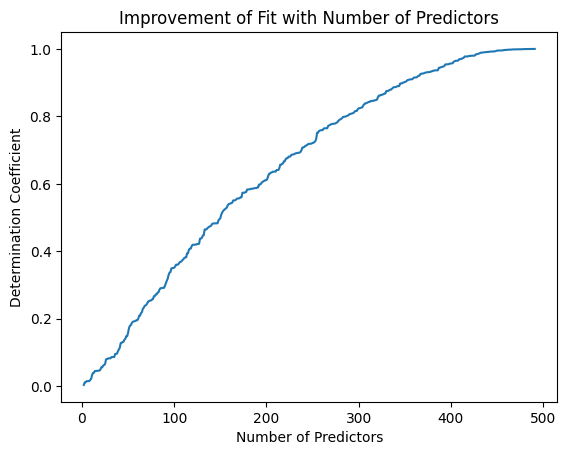

In [7]:
plt.plot(range(2, 492), rSquared)
plt.title("Improvement of Fit with Number of Predictors")
plt.xlabel("Number of Predictors")
plt.ylabel("Determination Coefficient");

In [8]:
n_orig = np.where(np.array(rSquared) >= 0.9)[0].min()
n_orig

346

In [9]:
from sklearn.decomposition import PCA

In [10]:
xPCA = PCA(n_components=491)
xPCA.fit(X)

PCA(n_components=491)

In [11]:
def rel_imp_me(X, y):
    names = X.columns
    ser = pd.Series(index = names)
    lm0 = sm.OLS(y, sm.add_constant(X)).fit()
    for c in names:
        lm = sm.OLS(y, sm.add_constant(X[names.drop(c)])).fit()
        ser[c] = lm0.rsquared - lm.rsquared
    res = pd.DataFrame(columns =['last', 'first', 'betasq', 'pratt'], index=names)
    res['last'] = ser
    corr = X.apply(lambda x: np.corrcoef(y,x)[0,1], axis=0)
    res['first'] = corr**2
    sx = X.std()
    res['betasq'] = (lm0.params[names] * sx / np.std(y))**2
    res['pratt'] = (lm0.params[names] * sx / np.std(y)) * corr
    return res

In [12]:
factorScores = pd.DataFrame(np.dot(X, xPCA.components_.T), columns =["PC%i"%(j+1) for j in range(491)])

In [13]:
metricsPCA = rel_imp_me(factorScores, Y)
metrics_first_rankPCA = metricsPCA["first"].rank(ascending=False, method='first')

In [14]:
PC_sorted = pd.DataFrame({"Predictors" : metrics_first_rankPCA.index,
                          "Rank" : metrics_first_rankPCA.values}).sort_values(by="Rank")
PC_sorted

,Predictors,Rank
1,PC2,1.0
3,PC4,2.0
16,PC17,3.0
113,PC114,4.0
45,PC46,5.0
...,...,...
490,PC491,487.0
242,PC243,488.0
468,PC469,489.0
475,PC476,490.0


In [15]:
orderedPC = pd.DataFrame(factorScores, columns=PC_sorted["Predictors"])

In [16]:
fits_PCA = [sm.OLS(Y, orderedPC.iloc[:,:j]).fit() for j in range(2,492)]

In [17]:
rSquared_PCA = [fit.rsquared for fit in fits_PCA]

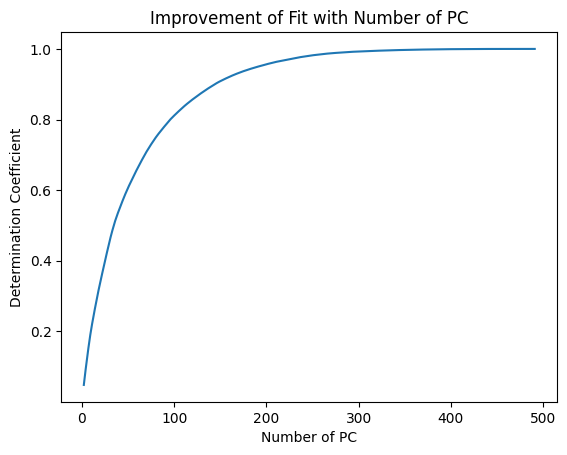

In [18]:
plt.plot(range(2, 492), rSquared_PCA)
plt.title("Improvement of Fit with Number of PC")
plt.xlabel("Number of PC")
plt.ylabel("Determination Coefficient");

In [19]:
n_PCA = np.where(np.array(rSquared_PCA) >= 0.9)[0].min()
n_PCA

143

In [20]:
MDR = n_orig - n_PCA
MDR

203

In [21]:
rSquared_PCA[143]

0.9013949387738441